# Lecture 3 Demo

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

import qiskit as qs
import qiskit.quantum_info as qi
import qiskit.visualization as qv
import qiskit_ibm_runtime as ibm
import qiskit_aer as aer

from qiskit.transpiler import generate_preset_pass_manager

## Setting up a hardware backend, the usual way

**Note:** You <u>must</u> ignore the `name='rpi-quantum'` in the call to `QiskitRuntimeService`! You only need to set a `name` if you have multiple accounts (see: [Qiskit documentation)](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.QiskitRuntimeService) if you want to set this up.)

In [4]:
# Setup the hardware backend
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
backend = service.backend('ibm_rensselaer')

## Setting up a local simulator

In Qiskit, we use the `AerSimulator` module to create local simulators that can model the behavior of perfect, noiseless qubits, as well as hardware backends and custom machines that you define. This is helpful for debugging, for small circuits where you want a faster turnaround, and for comparing with "ideal" results when you're unsure of how badly noise impacts your result. 

The full documentation for [AerSimulator](https://qiskit.github.io/qiskit-aer/) is located at: https://qiskit.github.io/qiskit-aer/.

In [5]:
# Setup the simulator backend
simulator = aer.AerSimulator()
sim_sampler = ibm.SamplerV2(mode=simulator)

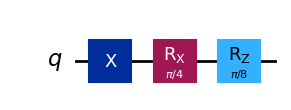

In [6]:
from qiskit import QuantumCircuit
import numpy as np

circ = QuantumCircuit(1)
circ.x(0)
circ.rx(np.pi/4, 0)
circ.rz(np.pi/8, 0)

circ.draw("mpl")

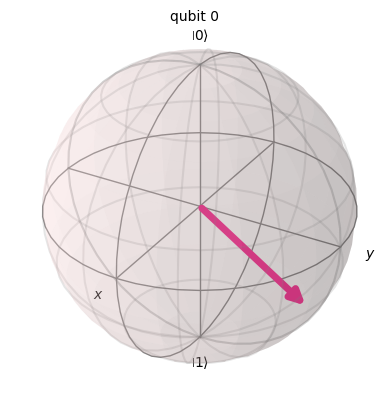

In [7]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

state = Statevector(circ)

plot_bloch_multivector(state)

In [8]:
state.draw("latex")

<IPython.core.display.Latex object>

# Measuirng in other bases

Measuring in just the statndard basis doesn't always give us all the information we need on what our quantum state is telling us. We measure in other bases to extract more information and increase our state of knowledge about the system, which lets us make better decisions on the classical side of the computation.

## Single Qubit Example

When we have a single qubit, we can create a quantum "coin" by applying a Hadamard gate to the qubit. This rotates the qubit from the $|0\rangle$ state to the $\frac{|0\rangle +|1\rangle}{\sqrt{2}}$. When we do a measurement operation at the end of the circuit, we see a 0 or a 1 with a 50-50 probability.

In [9]:
coin = QuantumCircuit(1)
coin.h(0)

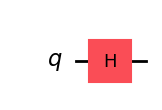

In [10]:
coin.draw(output='mpl')

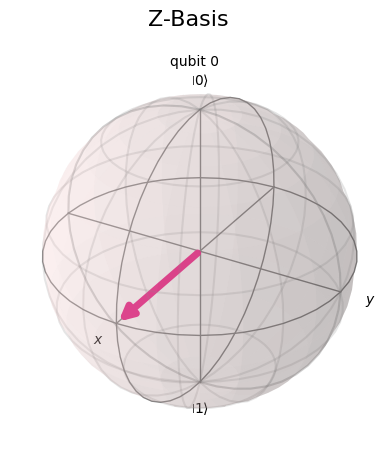

In [11]:
# Get the statevector from the circuit
state = Statevector.from_instruction(coin)

# Plot the statevector on the Bloch sphere
plot_bloch_multivector(state, title='Z-Basis')

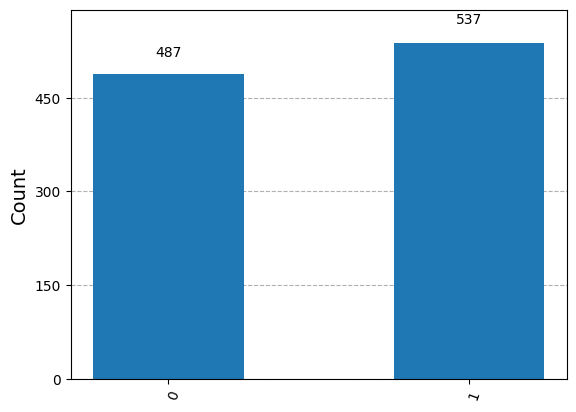

In [12]:
coin.measure_active()

sim_sampler = ibm.SamplerV2(mode=simulator)
sim_job = sim_sampler.run([coin])
result = sim_job.result()
coin_counts = result[0].data.measure.get_counts()

qv.plot_histogram(coin_counts)

## Measuring in Other Basis States
We call $|0\rangle$ and $|1\rangle$ the computational basis states, since they correspond to the classical bit values of 0 and 1. However, recall the Bloch sphere is a 3D unit sphere, so we have basis states corresponding to all three Cartesian directions:

**X**: $$|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}, |-\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}$$

**Y**: $$|i\rangle = \frac{|0\rangle + i|1\rangle}{\sqrt{2}}, |-i\rangle = \frac{|0\rangle - i|1\rangle}{\sqrt{2}}$$

**Z**: $$|0\rangle, |1\rangle$$

Measuring in just the Z-basis isn't always sufficient if we need to make use of the information that's stored along other dimensions of the the qubit's statevector. If we want to measure in another basis, we need to do a coordinate transformation from the Z-basis to the new basis as our *final* operation before we perform the measurement.

### Measuring in the X-basis
The X-basis (also called the Hadamard basis) lies in the +/- X direction on the Bloch sphere. We can take any statevector in the Z-basis and transform it to the X-basis using the Hadamard gate. For this example with the quantum coin, we wind up with a trivial answer! The first Hadamard gate we applied put our statevector in the $|+\rangle$ state, so applying a second one brings us back to the $|0\rangle$, meaning we will measure `0` 100% of the time. The same as if we had measured $|+\rangle$ in the X-basis directly.

In [13]:
coin = QuantumCircuit(1)
coin.h(0)

# Now apply the basis transformation
coin.h(0)

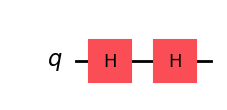

In [14]:
coin.draw(output='mpl')

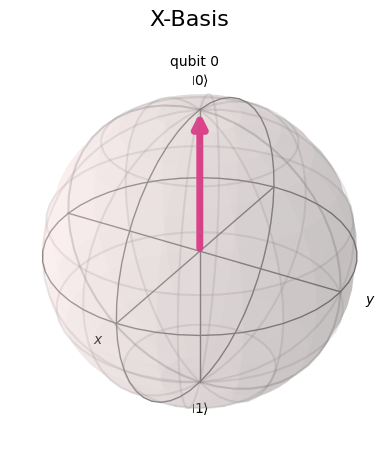

In [15]:
# Get the statevector from the circuit
state = Statevector.from_instruction(coin)

# Plot the statevector on the Bloch sphere
plot_bloch_multivector(state, title='X-Basis')

Since we're 100% in the $|+\rangle$ state, measureing in the X basis will give us 100% probability of seeing that state.

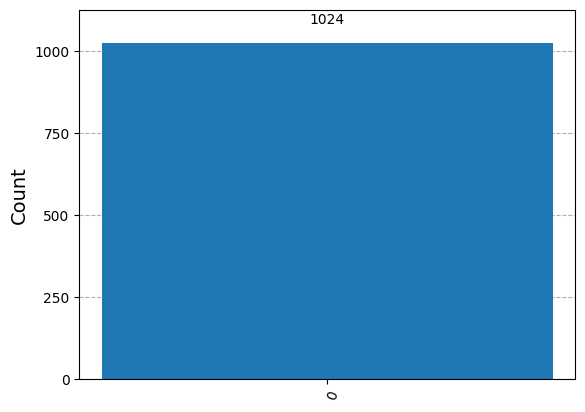

In [16]:
coin.measure_active()

sim_sampler = ibm.SamplerV2(mode=simulator)
sim_job = sim_sampler.run([coin])
result = sim_job.result()
coin_counts = result[0].data.measure.get_counts()

qv.plot_histogram(coin_counts)

### Measuring in the Y-basis
Measuring in the Y-basis requires a rotation of the statevector into the $|i\rangle$ state, which is accomplished by first appling a $\mathbf{S}^\dagger$ gate to rotate counterclockwise around the Z-axis by $\frac{\pi}{2}$, followed by a Hadamard gate to rotate down by $\frac{\pi}{2}$.

In [17]:
coin = QuantumCircuit(1)
coin.h(0)
# Apply the basis transformation
coin.sdg(0)
# coin.h(0)

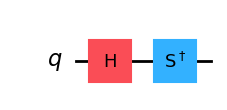

In [18]:
coin.draw(output='mpl')

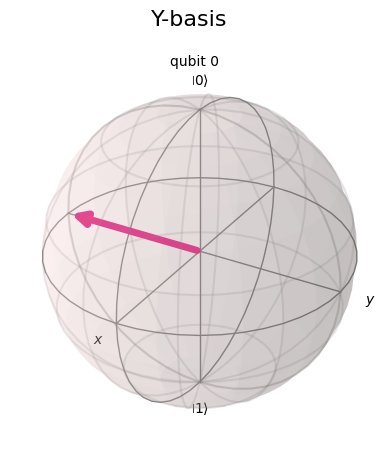

In [19]:
# Get the statevector from the circuit
state = Statevector.from_instruction(coin)

# Plot the statevector on the Bloch sphere
plot_bloch_multivector(state, title='Y-basis')

Since $|+\rangle$ is still the same 50-50 superposition with respect to Y, we will still see a 50-50 distribution when we measure. 

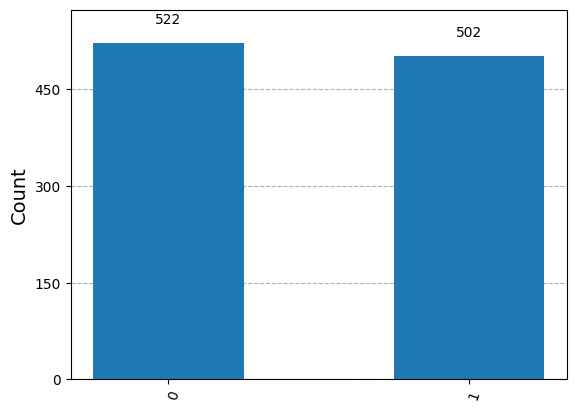

In [20]:
coin.measure_active()

sim_sampler = ibm.SamplerV2(mode=simulator)
sim_job = sim_sampler.run([coin])
result = sim_job.result()
coin_counts = result[0].data.measure.get_counts()

qv.plot_histogram(coin_counts)

# Estimators and Expectation Values

Let's now repeat our experiments above using the Estimator primitive. This will give us the expectation value of our quantum coin with resepect to different measurement observables.

In [21]:
sim_estimator = ibm.EstimatorV2(mode=simulator)

We start by making our quantum circuit. In Estimator jobs, we do not need to define any measurements (you'll get an error). The base circuit is enough.

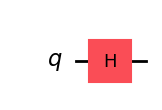

In [22]:
n_qubits = 1

coin = qs.QuantumCircuit(n_qubits)
coin.h(0)

coin.draw(output='mpl')

Now we define our observable using the `SparsePauliOp` object in `qiskit.quantum_info`. 

In [25]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp("Z" * n_qubits)
print(f">>> Observable: {observable.paulis}")

>>> Observable: ['Z']


In [32]:
sim_estimator.options.default_shots = 8192

job = sim_estimator.run([(coin, observable)])
result = job.result()

print(f"  > Expectation value: {result[0].data.evs}")
print(f"  > Metadata: {result[0].metadata}")

  > Expectation value: 0.001586720371048456
  > Metadata: {'target_precision': 0.011048543456039804, 'shots': 8193, 'circuit_metadata': {}}


In [26]:
state = qi.Statevector.from_instruction(coin)
H = observable.to_matrix()

state.expectation_value(H)

np.complex128(0j)

Note how the expectation value converges on the analytical value as we increase the number of shots.

## In other bases

We can change our `SparsePauliOp` to a different basis to get the expectation value in that direction:

In [33]:
observable = qi.SparsePauliOp("X" * n_qubits)

job = sim_estimator.run([(coin, observable)])
result = job.result()

print(f"  > Expectation value: {result[0].data.evs}")
print(f"  > Metadata: {result[0].metadata}")

  > Expectation value: 1.0
  > Metadata: {'target_precision': 0.011048543456039804, 'shots': 8193, 'circuit_metadata': {}}


In [34]:
observable = qi.SparsePauliOp("Y" * n_qubits)

job = sim_estimator.run([(coin, observable)])
result = job.result()

print(f"  > Expectation value: {result[0].data.evs}")
print(f"  > Metadata: {result[0].metadata}")

  > Expectation value: 0.012815818381545222
  > Metadata: {'target_precision': 0.011048543456039804, 'shots': 8193, 'circuit_metadata': {}}


## What about the 0 or 1 State?
When we measure with respect to these Pauli operators, we get an answer in the range [-1,1]. What do we do if we want an answer in the range of [0,1]?

A: We have to use the Pauli expressions to recreate the Projection operator for the 0 or 1 state!

$P_0 = \frac{I+Z}{2} = \frac{1}{2}\left(\begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix} + \begin{pmatrix}1 & 0 \\ 0 & 1\end{pmatrix}\right) = \begin{pmatrix}1 & 0 \\ 0 & 0\end{pmatrix}$

$P_1 = \frac{I-Z}{2} = \frac{1}{2}\left(\begin{pmatrix}1 & 0 \\ 0 & 1\end{pmatrix} - \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}\right) = \begin{pmatrix}0 & 0 \\ 0 & 1\end{pmatrix}$

In [35]:
observable = qi.SparsePauliOp(["I", "Z"],
                              [0.5, -0.5])

job = sim_estimator.run([(coin, observable)])
result = job.result()

print(f"  > Expectation value: {result[0].data.evs}")
print(f"  > Metadata: {result[0].metadata}")

  > Expectation value: 0.5034785792749908
  > Metadata: {'target_precision': 0.011048543456039804, 'shots': 8193, 'circuit_metadata': {}}


In [31]:
from qiskit import circuit

for angle in 
:
  rx = circuit.library.RXGate(0, 0).to_matrix()
  

TypeError: label expects a string or None

## Sweeping Parameters

In many quantum algorithms, we want to vary some parameter to see how the measurement varies. This is common in variational algorithms, in machine learning problems, and optimization. Qiskit lets us define lists of parameters that will generate circuits for us, so we don't need to loop manualy and potentially take longer and introduce more error as the machine drifts.

In this example, we'll vary the rotation angle of the qubit around the X-axis and measure the expectation value with respect to the Z observable at each point. We begin by using `numpy` to create an array of rotataion angles:

In [35]:
number_of_angles = 21

angles = np.linspace(0, 2 * np.pi, number_of_angles)

# Phases need to be expressed as list of lists in order to work
individual_angles = [[angle] for angle in angles]

print(angles)

[0.         0.31415927 0.62831853 0.9424778  1.25663706 1.57079633
 1.88495559 2.19911486 2.51327412 2.82743339 3.14159265 3.45575192
 3.76991118 4.08407045 4.39822972 4.71238898 5.02654825 5.34070751
 5.65486678 5.96902604 6.28318531]


Now, let's create a circuit where we can vary the rotation angle around the X-axis using the $\mathbf{R_x}$ gate. We use the `qiskit.circuit.Parameter` object to represent our angle values, which will be populated when we run the circuit.

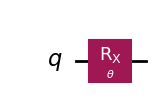

In [37]:
from qiskit import circuit

theta = circuit.Parameter("$\\theta$")

circ = QuantumCircuit(1)
circ.rx(theta, 0)

circ.draw('mpl')

Next, we create an observable on the Pauli-Z operator:

In [38]:
observable = SparsePauliOp("Z")

To run this in an Estimator, Qiskit needs us to create a PUB (primitive unified blocks) containing the circuit, observable, and parameter set. We do this by making a tuple data structure:

In [39]:
pub = (circ, [observable], individual_angles)

Now, we can run the full job to get a list of the expectation values as a funtion of angle.

In [40]:
job_result = sim_estimator.run(pubs=[pub]).result()

Once the job has run, we collect the expectation values and their standard deviations from the job result.

In [41]:
evs = job_result[0].data.evs
stds = job_result[0].data.stds

In [36]:
from qiskit import circuit

for angle in angles:
  rx = circuit.library.RXGate(angle).to_matrix()
  exp = zero_state.conj().T @ rx @ zero_state
  exps_ref.append(exp)

exps_ref = np.array(exps_ref)

NameError: name 'zero_state' is not defined

Finally, we can plot the result and confirm the sinusoidal shape of the expectation value plot with respect to the Z-observable.

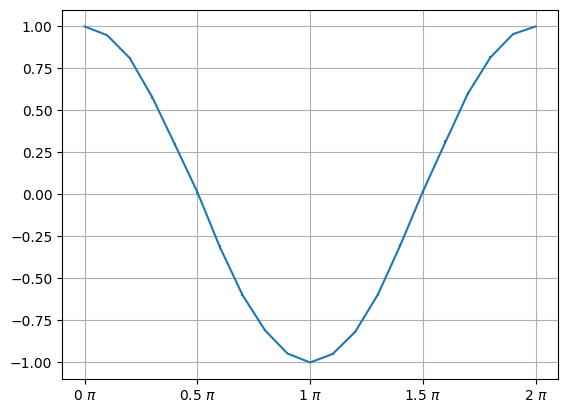

In [42]:
fig, ax = plt.subplots()

ax.errorbar(angles/np.pi, evs, yerr=stds)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
plt.grid()
plt.show()

In [34]:
plt.plot(angles/np.pi, exps_ref)

NameError: name 'angles' is not defined

## Multi-Qubit Estimators

In [43]:
phiplus = QuantumCircuit(2)

phiplus.h(0)
phiplus.cx(0, 1)

phiminus = QuantumCircuit(2)

phiminus.x(0)
phiminus.h(0)
phiminus.cx(0, 1)

In [44]:
# Set up six different observables. 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

In [45]:
job = sim_estimator.run([(phiplus, observables), (phiminus, observables)])
result = job.result()

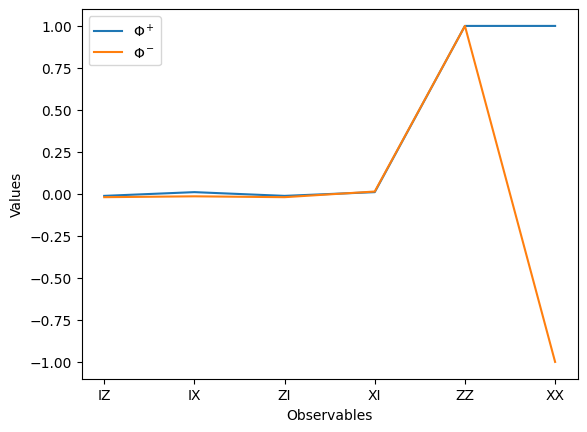

In [46]:
ev_plus = result[0].data.evs
ev_minus = result[1].data.evs
 
# plotting graph
#plt.plot(observables_labels, ev_plus, ev_minus, 'o')
plt.plot(observables_labels, ev_plus, label=r'$\Phi^+$')
plt.plot(observables_labels, ev_minus, label=r'$\Phi^-$')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.legend()
plt.show()